In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx

______________________________

In [3]:
network = 'tarbase'
ppi_network = 'preppi'
target_homology = 'mix'

lca_source = 'mirgenedb'  # Options: 'mirgenedb' or 'ensembl'

remove_SSD_pre_2R = False
keep_SSD_pre_2R = False

if remove_SSD_pre_2R and keep_SSD_pre_2R:
	raise ValueError("Cannot both remove and keep pre-2R SSD pairs. Choose one option or remove both.")

if remove_SSD_pre_2R:
	s = 'post_2R'
elif keep_SSD_pre_2R:
	s = 'pre_2R'
else:
	s = ''

remove_large_fam = True
if remove_large_fam:
	max_n_nodes = 4
	s += f'cc_largerthan{str(max_n_nodes)}_removed'

remove_undistinguished_pairs = True
if remove_undistinguished_pairs:
	s += '_undistinguished_pairs_removed'

In [4]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.{ppi_network}.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.{ppi_network}.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.{ppi_network}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{ppi_network}.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.{ppi_network}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{ppi_network}.tsv'
else:
	raise ValueError("target_homology must be either 'wgd', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [5]:
ensembl_mirna_pair_lca_file_path = '../../3_retrieve_Hsa_paralogs/all_hsa_ensembl_paralogmirna_clean.tsv'
df_mirna_pair_lca = pd.read_csv(ensembl_mirna_pair_lca_file_path, sep='\t', header=None)
ensembl_pair_lca_dict = {}
for _, row in df_mirna_pair_lca.iterrows():
	ensembl_pair_lca_dict[(row[1], row[3])] = row[4]
	ensembl_pair_lca_dict[(row[3], row[1])] = row[4]

In [6]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirgenedb_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin[[8, 14, 15]]
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirgenedb_mirna_origin.columns = cols
df_mirgenedb_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirgenedb_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

In [7]:
ordered_lca = {
	'Eumetazoa': 0,
	'Bilateria': 1,
	'Nephrozoa': 2,
	'Chordata': 3,
	'Olfactores': 4,
	'Vertebrata': 5,
	'Gnathostomata': 6,
	'Osteichthyes': 7,
	'Euteleostomi': 8,
	'Sarcopterygii': 9,
	'Tetrapoda': 10,
	'Amniota': 11,
	'Mammalia': 12,
	'Theria': 13,
	'Eutheria': 14,
	'Boroeutheria': 15,
	'Euarchontoglires': 16,
	'Primates': 17,
	'Simiiformes': 18,
	'Catarrhini': 19,
	'Hominidae': 20,
	'Homo_sapiens': 21
}

reverted_ordered_lca_dict = {v: k for k, v in ordered_lca.items()}

In [8]:
df_wgd = df_1
df_ssd = df_2

In [9]:
if remove_undistinguished_pairs:
	df_wgd = df_wgd[~((df_wgd['n_common_targets'] == df_wgd['n_tar_1']) & (df_wgd['n_common_targets'] == df_wgd['n_tar_2']))]
	df_ssd = df_ssd[~((df_ssd['n_common_targets'] == df_ssd['n_tar_1']) & (df_ssd['n_common_targets'] == df_ssd['n_tar_2']))]

In [10]:
def add_ensembl_lca(df, dict):
    df_cp = df.copy()
    df_cp['lca'] = df_cp.apply(lambda row: dict.get((row['miRNA_1'], row['miRNA_2'])), axis=1)
    return df_cp

def add_mirgenedb_lca(df, single_miRNA_dict, dict):
	reverted_dict = {v: k for k, v in dict.items()}
	def compute_max_lca(miRNA):
		# If the miRNA value itself is NaN/null, skip immediately
		if pd.isna(miRNA):
			return -1
		# Look up its list of lno’s; if that’s not a list/tuple, treat as empty
		lno_list = single_miRNA_dict.get(miRNA, [])
		if not isinstance(lno_list, (list, tuple)):
			return -1
		# Map to ordered_lca values and take the max (or -1 if empty)
		return max((dict.get(lno, -1) for lno in lno_list), default=-1)
    
	df_cp = df.copy()
	df_cp['lca_1'] = df_cp['miRNA_1'].apply(compute_max_lca)
	df_cp['lca_2'] = df_cp['miRNA_2'].apply(compute_max_lca)
	df_cp['lca_code'] = df_cp[['lca_1', 'lca_2']].max(axis=1)
	df_cp = df_cp.drop(columns=['lca_1', 'lca_2'])
	df_cp['lca'] = df_cp['lca_code'].apply(
		lambda code: reverted_dict.get(code, 'Unknown')
	)
	df_cp = df_cp.drop(columns=['lca_code'])
	return df_cp

if lca_source == "ensembl":
    print("Using Ensembl for LCA")
    df_wgd_lca = add_ensembl_lca(df_wgd, ensembl_pair_lca_dict)
    df_ssd_lca = add_ensembl_lca(df_ssd, ensembl_pair_lca_dict)
elif lca_source == "mirgenedb":
    print("Using MirGeneDB for LCA")
    df_wgd_lca = add_mirgenedb_lca(df_wgd, mirna_lno_dict, reverted_ordered_lca_dict)
    df_ssd_lca = add_mirgenedb_lca(df_ssd, mirna_lno_dict, reverted_ordered_lca_dict)
else:
    raise ValueError(f"{lca_source} is an invalid LCA source. Using MirGeneDB.")


Using MirGeneDB for LCA


In [11]:
df_wgd_lca[df_wgd_lca['lca']=='None']

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca


In [12]:
df_ssd_lca

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca
0,MIR100,MIR10A,136,272,7,0.005,0.070534,1,5,14.106735979665881,0.0,Unknown
1,MIR100,MIR10B,136,141,6,0.003,0.054690,0,1000,-0.05485459945386285,1.0,Unknown
2,MIR100,MIR125A,136,306,8,0.007,0.083373,0,1000,-0.08396038004871988,1.0,Unknown
3,MIR100,MIR125B1,136,270,7,0.004,0.063119,0,1000,-0.06337242505244779,1.0,Unknown
4,MIR100,MIR125B2,136,367,12,0.005,0.070534,0,1000,-0.07088812050083357,1.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
1378,MIRLET7F1,MIRLET7G,543,620,453,0.207,0.517833,2,28,3.4625063545991566,6.486374895309233e-05,Unknown
1379,MIRLET7F1,MIRLET7I,543,478,436,0.120,0.334066,3,0,8.621054497285195,1.27675647831893e-14,Unknown
1380,MIRLET7F2,MIRLET7G,519,620,453,0.170,0.406325,2,12,4.503783993537902,1.0272212791484492e-06,Unknown
1381,MIRLET7F2,MIRLET7I,519,478,436,0.099,0.318118,3,1,9.119260424011125,0.0,Unknown


In [13]:
print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  1347


In [14]:
df_ssd_lca

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca
0,MIR100,MIR10A,136,272,7,0.005,0.070534,1,5,14.106735979665881,0.0,Unknown
1,MIR100,MIR10B,136,141,6,0.003,0.054690,0,1000,-0.05485459945386285,1.0,Unknown
2,MIR100,MIR125A,136,306,8,0.007,0.083373,0,1000,-0.08396038004871988,1.0,Unknown
3,MIR100,MIR125B1,136,270,7,0.004,0.063119,0,1000,-0.06337242505244779,1.0,Unknown
4,MIR100,MIR125B2,136,367,12,0.005,0.070534,0,1000,-0.07088812050083357,1.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
1378,MIRLET7F1,MIRLET7G,543,620,453,0.207,0.517833,2,28,3.4625063545991566,6.486374895309233e-05,Unknown
1379,MIRLET7F1,MIRLET7I,543,478,436,0.120,0.334066,3,0,8.621054497285195,1.27675647831893e-14,Unknown
1380,MIRLET7F2,MIRLET7G,519,620,453,0.170,0.406325,2,12,4.503783993537902,1.0272212791484492e-06,Unknown
1381,MIRLET7F2,MIRLET7I,519,478,436,0.099,0.318118,3,1,9.119260424011125,0.0,Unknown


In [15]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

if remove_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[~df_ssd_lca['lca'].isin(pre_2R_clades)]
if keep_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[df_ssd_lca['lca'].isin(pre_2R_clades)]

print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  1347


In [16]:
def remove_large_cc(df, max_size):
    df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['miRNA_1'], row['miRNA_2'])

    # Identify connected components
    large_components = [comp for comp in nx.connected_components(G) if len(comp) > max_size]

    if not large_components:
        return df

    # Process each large component separately
    indices_to_keep = set()

    for comp in large_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        top_pairs = comp_df.nlargest(max_size, 'Z-score')
        #indices_to_keep.update(top_pairs.index)

    # Identify edges to retain from small components
    small_components = [comp for comp in nx.connected_components(G) if len(comp) <= max_size]
    for comp in small_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        indices_to_keep.update(comp_df.index)

    return df.loc[sorted(indices_to_keep)].reset_index(drop=True)

In [17]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd_lca = remove_mirna_pairs(df_ssd_lca, df_wgd_lca)

print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd_lca))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd_lca))

Number of WGD pairs after removing miRNA pairs from SSD:  101
Number of SSD pairs after removing miRNA pairs from SSD:  1247


In [18]:
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

if remove_large_fam:
	max_n_nodes = 4
	df_ssd_lca_parsed = remove_large_cc(remove_sigma_err(df_ssd_lca), max_n_nodes)
	df_wgd_lca_parsed = remove_large_cc(remove_sigma_err(df_wgd_lca), max_n_nodes)
else:
	df_ssd_lca_parsed = remove_sigma_err(df_ssd_lca)
	df_wgd_lca_parsed = remove_sigma_err(df_wgd_lca)

/tmp/ipykernel_1950/4003812063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')
/tmp/ipykernel_1950/4003812063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')


In [19]:
df_wgd_lca_zscores = df_wgd_lca_parsed['Z-score'].astype(float)
df_ssd_lca_zscores = df_ssd_lca_parsed['Z-score'].astype(float)

df_wgd_lca_nbifan = df_wgd_lca_parsed['n_relevant_bifan'].astype(int)
df_ssd_lca_nbifan = df_ssd_lca_parsed['n_relevant_bifan'].astype(int)

In [20]:
n_wgd = len(df_wgd_lca_zscores)
n_ssd = len(df_ssd_lca_zscores)

print("n_wgd in the boxplot: ", n_wgd)
print("n_ssd in the boxplot: ", n_ssd)

n_wgd in the boxplot:  99
n_ssd in the boxplot:  39


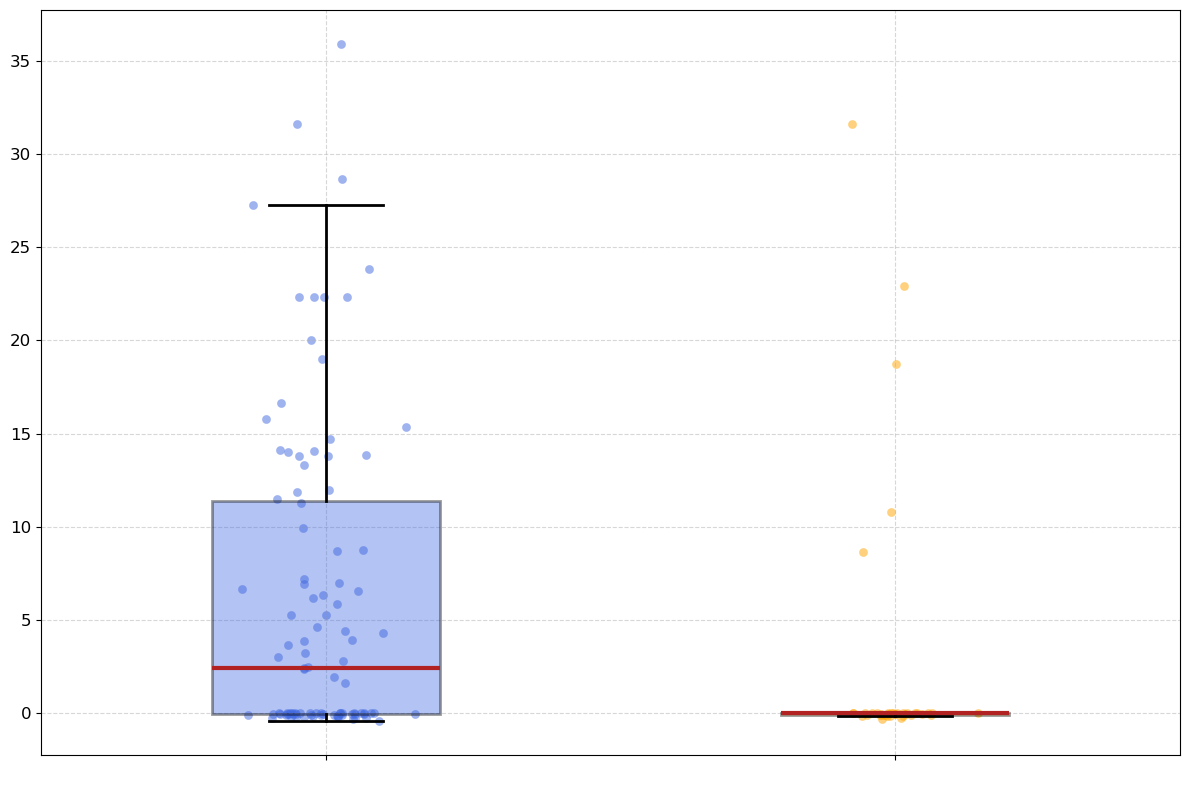

Number of WGD pairs: 99
Number of SSD pairs: 39


In [21]:
data = [df_wgd_lca_zscores, df_ssd_lca_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
#plt.ylim(-3, 75)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

print(f"Number of WGD pairs: {len(df_wgd_lca_parsed)}")
print(f"Number of SSD pairs: {len(df_ssd_lca_parsed)}")

In [22]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_lca_zscores, df_ssd_lca_zscores)
print(f"KS test results with parameters:\nnetwork={network}\ntarget_homology={target_homology}\nremove_pre_2R={remove_SSD_pre_2R}")
print(75 * "=")
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS test results with parameters:
network=tarbase
target_homology=mix
remove_pre_2R=False
KS statistic: 0.40714840714840717, p-value: 0.00010843929564770484


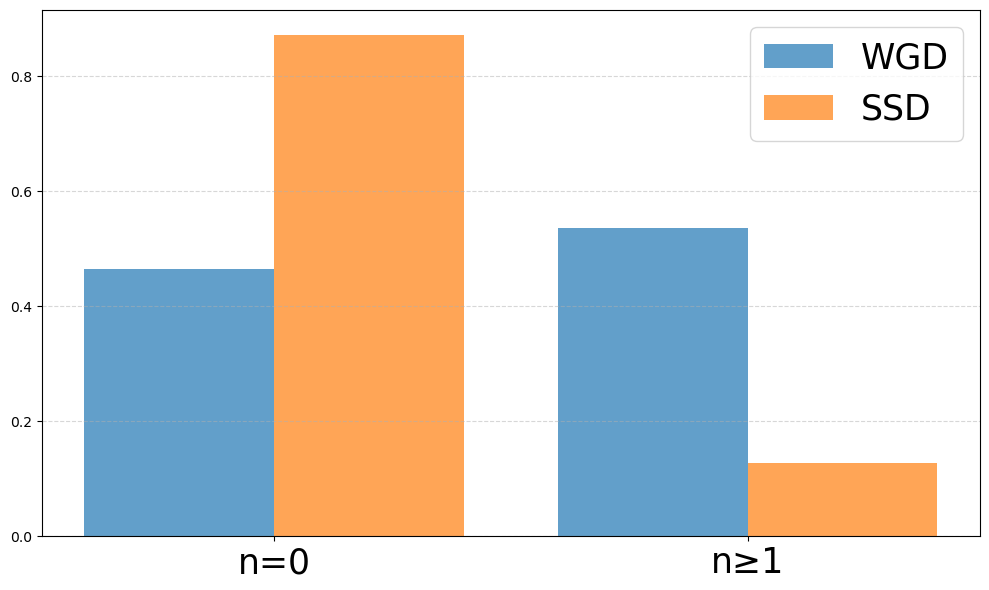

In [23]:
labels = ['n=0', 'n≥1']

def bin_bifans(count, labels=labels):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_lca_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_lca_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

________________________________________

## Subgenome analysis

In [24]:
subg_file = '../../1.1_retrieve_Hsa_ohnomirnas/gnathostomata_ohnolog_reference_singlecol.gene.tsv'
df_subg = pd.read_csv(subg_file, sep='\t', header=None)
cols = ['miRNA', 'subgenome', 'CLG']
df_subg.columns = cols
df_subg

def label_subgenome(df_dup, df_subg, prefix):
    # Create a dictionary from df_subg (miRNA -> subgenome)
    subg_dict = dict(zip(df_subg['miRNA'], df_subg['subgenome']))

    # Function to translate and label each miRNA
    def translate_miRNA(miRNA):
        miRNA_clean = miRNA.replace(prefix, "")
        return subg_dict.get(miRNA_clean, 'unknown')

    # Apply subgenome labels
    df_dup_cp = df_dup.copy()
    df_dup_cp['subg_1'] = df_dup_cp['miRNA_1'].apply(translate_miRNA)
    df_dup_cp['subg_2'] = df_dup_cp['miRNA_2'].apply(translate_miRNA)

    # Split into numeric and Greek part
    df_dup_cp['miRNA_1_1R'] = df_dup_cp['subg_1'].str.extract(r'(\d)')
    df_dup_cp['miRNA_1_2R'] = df_dup_cp['subg_1'].str.extract(r'(alpha|beta)')

    df_dup_cp['miRNA_2_1R'] = df_dup_cp['subg_2'].str.extract(r'(\d)')
    df_dup_cp['miRNA_2_2R'] = df_dup_cp['subg_2'].str.extract(r'(alpha|beta)')

    return df_dup_cp

df_wgd_lca_parsed_subg = label_subgenome(df_wgd_lca_parsed, df_subg, '')

n_1 =  31
n_2 =  33
n_3 =  26
n_4 =  9


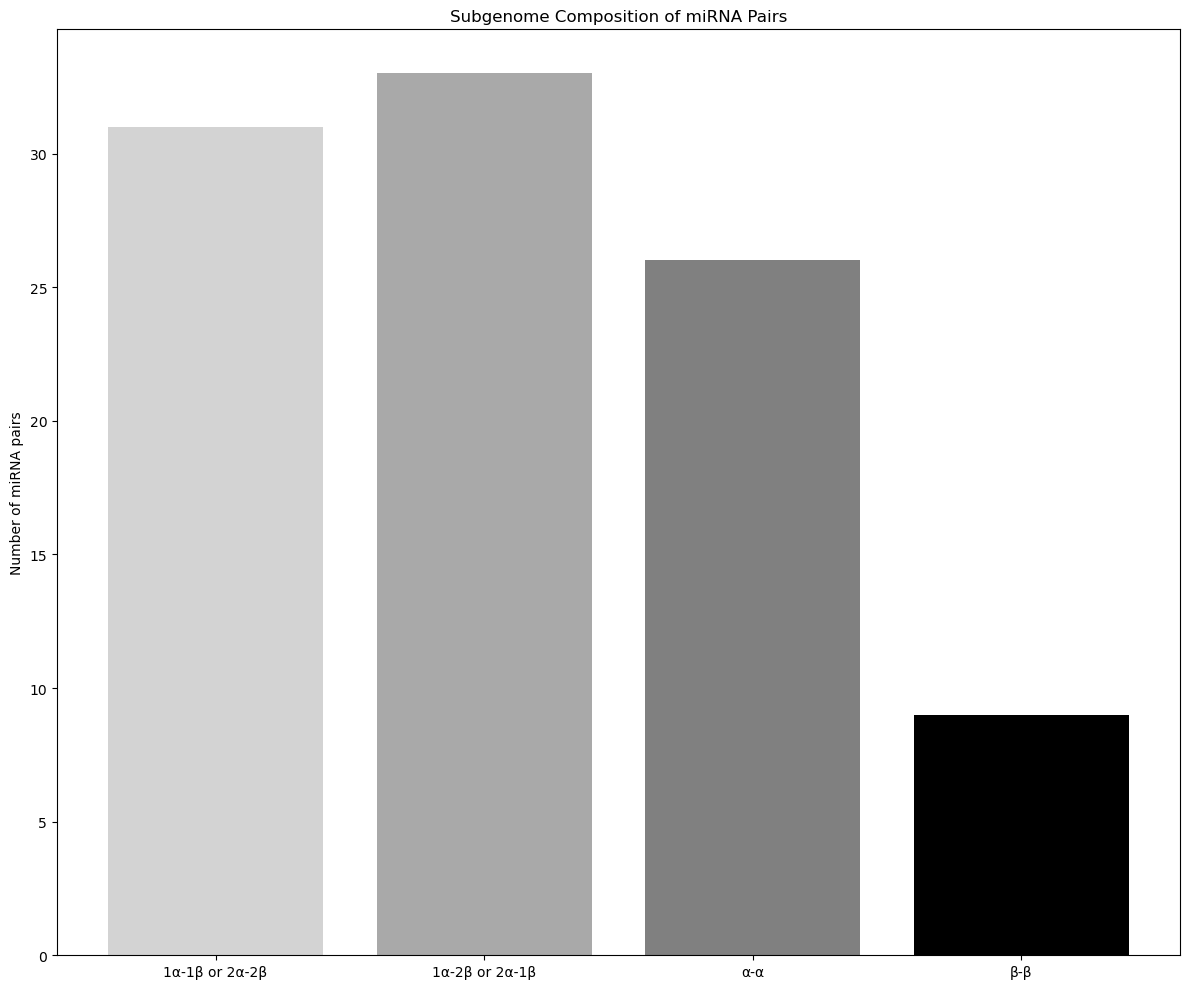

In [25]:
mask_1 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_2 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_3 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') 
)

mask_4 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') 
)

# add a column named "dup_subgenome_type" with "A" if mask_1 is True, "B" if mask_2 is True, and "C" if mask_3 is True
df_wgd_lca_parsed_subg['dup_subgenome_type'] = np.select(
	[mask_1, mask_2, mask_3, mask_4],
	['A', 'B', 'C', 'D']
)

n_1 = df_wgd_lca_parsed_subg[mask_1].shape[0]
n_2 = df_wgd_lca_parsed_subg[mask_2].shape[0]
n_3= df_wgd_lca_parsed_subg[mask_3].shape[0]
n_4 = df_wgd_lca_parsed_subg[mask_4].shape[0]

print("n_1 = ", n_1)
print("n_2 = ", n_2)
print("n_3 = ", n_3)
print("n_4 = ", n_4)

# Plot
plt.figure(figsize=(12, 10))
plt.bar(['1α-1β or 2α-2β', '1α-2β or 2α-1β', 'α-α', 'β-β'], [n_1, n_2, n_3, n_4], color=['lightgrey', 'darkgrey', 'grey', 'black'])
plt.ylabel('Number of miRNA pairs')
plt.title('Subgenome Composition of miRNA Pairs')
plt.tight_layout()
plt.show()

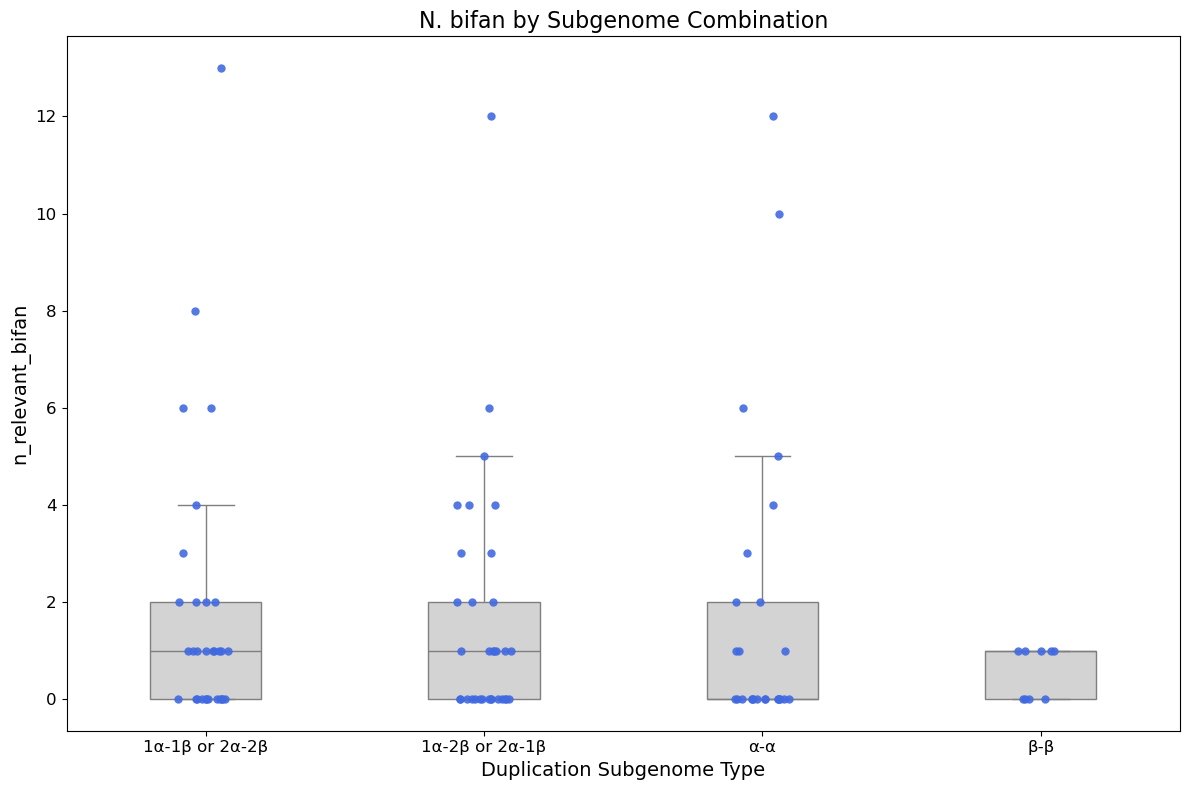

In [26]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='dup_subgenome_type', y='n_relevant_bifan', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='n_relevant_bifan', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], color='royalblue', alpha=0.9, s=6, jitter=True)
plt.xlabel('Duplication Subgenome Type', fontsize=14)
plt.ylabel('n_relevant_bifan', fontsize=14)
v = ['1α-1β or 2α-2β', '1α-2β or 2α-1β', 'α-α', 'β-β']
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.title('N. bifan by Subgenome Combination', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

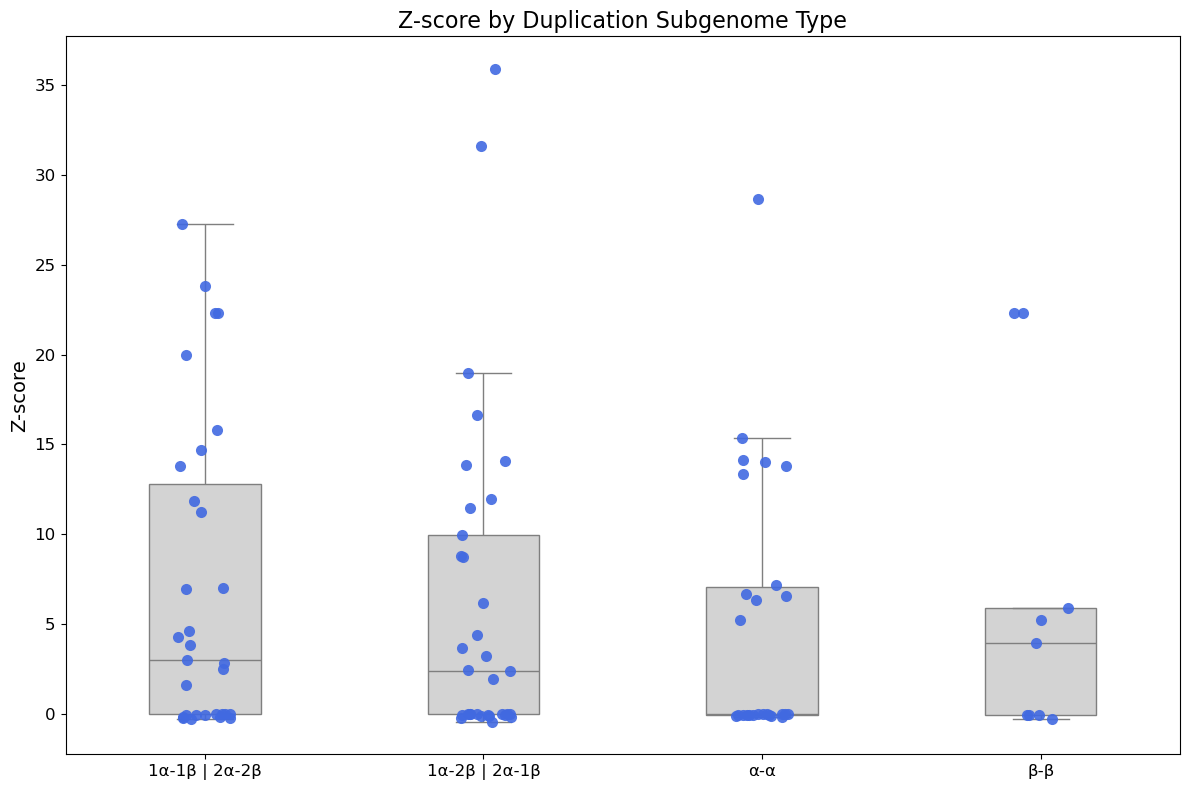

In [27]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], color='royalblue', alpha=0.9, s=8)
plt.xlabel('', fontsize=14)
plt.ylabel('Z-score', fontsize=14)
plt.title('Z-score by Duplication Subgenome Type', fontsize=16)
v = ['1α-1β | 2α-2β', '1α-2β | 2α-1β', 'α-α', 'β-β']
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

____________________

In [29]:
dict_path = '../../1.1_retrieve_Hsa_ohnomirnas/ohnomirna_mgdb_to_gene.dic'

dic = {}
with open(dict_path) as f:
	for line in f:
		parts = line.strip().split('\t')
		if len(parts) == 2:
			dic[parts[1]] = parts[0]

In [30]:
avg_expr_matrix_path = '../../miRNATissueAtlas_expression/all_human_miRNA_rpmm_harmonized_meta_data.mgdb.csv'

with open(avg_expr_matrix_path) as f:
    lines = [line.strip().split('\t') for line in f.readlines()[:4]]
    
columns = list(zip(*lines))
merged_header = ['{},{}'.format(columns[i][0], ','.join(columns[i][1:])) for i in range(len(columns))]
h = '\t'.join(merged_header)

expr_df = pd.read_csv(avg_expr_matrix_path, index_col=None, sep='\t', header=None)
expr_df = expr_df.iloc[4:, :]
expr_df.columns = h.split('\t')
expr_df.set_index(expr_df.columns[0], inplace=True)
expr_df = expr_df[expr_df.index != 'unknown_mirna']
expr_df = expr_df[expr_df.index != 'premirna_not_in_mirgenedb']
expr_df = expr_df.apply(pd.to_numeric)
expr_df = expr_df.loc[:, expr_df.columns.str.endswith('mean')]

expr_df

/tmp/ipykernel_1950/224704369.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,

,"EV,adipose,adipose,mean","EV,airway,epithelium,mean","EV,airway,pharynx,mean","EV,artery,artery,mean","EV,blood,GDM,mean","EV,blood,Molm14,mean","EV,blood,PBMC,mean","EV,blood,THP,mean","EV,blood,blood,mean","EV,blood,plasma,mean",...,"tissue,tongue,tongue,mean","tissue,tonsil,tonsil,mean","tissue,trachea,trachea,mean","tissue,umbilical_cord,huvec,mean","tissue,umbilical_cord,umbilical_cord,mean","tissue,urethra,urethra,mean","tissue,urine,urine,mean","tissue,uterus,uterus,mean","tissue,vaginal_tissue,vaginal_tissue,mean","tissue,vein,vein,mean"
"Biotype,Organ_system,Tissue,Metric",,,,,,,,,,,,,,,,,,,,,
Hsa-Let-7-P1b,1088.428021,243.546543,0.043313,219.914918,568.125633,194.249264,281.727338,42.597923,137.123529,565.522809,...,1485.267408,1012.027760,2450.948916,2259.509429,1271.972792,2476.532603,467.290950,1236.827140,2437.746786,776.000649
Hsa-Let-7-P1b,6.505383,4.492620,0.000000,47.933493,15.282738,2.515213,0.649421,0.401885,3.789879,3.072286,...,2.586946,5.930494,5.310115,11.823245,10.589435,4.679424,4.812450,6.962467,33.098248,4.027219
Hsa-Let-7-P1c,4.816620,0.000000,0.000000,44.683410,0.308100,12.401268,0.023610,0.000000,1.241202,1.098243,...,3.459201,5.605949,3.207017,11.017460,10.217927,4.434976,2.537118,1.827755,4.520438,1.293623
Hsa-Let-7-P1c,4765.081268,206.162963,0.557305,609.405956,87.788778,1595.478431,91.012267,197.572829,522.647640,1082.661796,...,4764.332005,2030.584158,8786.298873,2077.455856,1362.149626,8060.796190,1114.537047,2994.291358,12096.249358,2990.441585
Hsa-Let-7-P1d,0.582867,0.754825,0.000000,68.443741,0.179697,0.000000,0.000000,0.000000,0.469278,0.381515,...,0.365671,0.565189,1.068588,5.455957,2.780810,0.838106,7.392894,0.204405,1.249168,0.557457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hsa-Mir-96-P2,2.985072,1043.589374,6.907106,47.118951,55.192044,33.070895,151.360592,150.744449,425.107901,529.451015,...,310.940806,8656.767830,377.471680,43.859254,1297.497460,123.201543,182.363125,1748.267031,220.295288,207.660570
Hsa-Mir-96-P3,0.000000,2.507751,0.000000,35.292801,1.349744,0.206051,0.037953,0.025759,1.006019,0.453172,...,12.403298,9.526723,1.988102,0.032581,4.613867,1.466685,1.849835,0.908452,2.879971,0.497193
Hsa-Mir-96-P3,0.747757,842.679437,5.148449,36.157231,34.706521,22.573360,13.384168,96.518346,150.865892,346.188089,...,219.570064,593.713919,112.203670,4.740391,437.259549,43.511656,77.749900,174.234731,93.439187,60.275389
